# Project for the Technologies for Learning course (2020), under supervision of Sergey Sosnovsky.

## Group 7: Hessel Laman, Joren Wouters, Mitchell Klijs & Nathan van Gelderen.

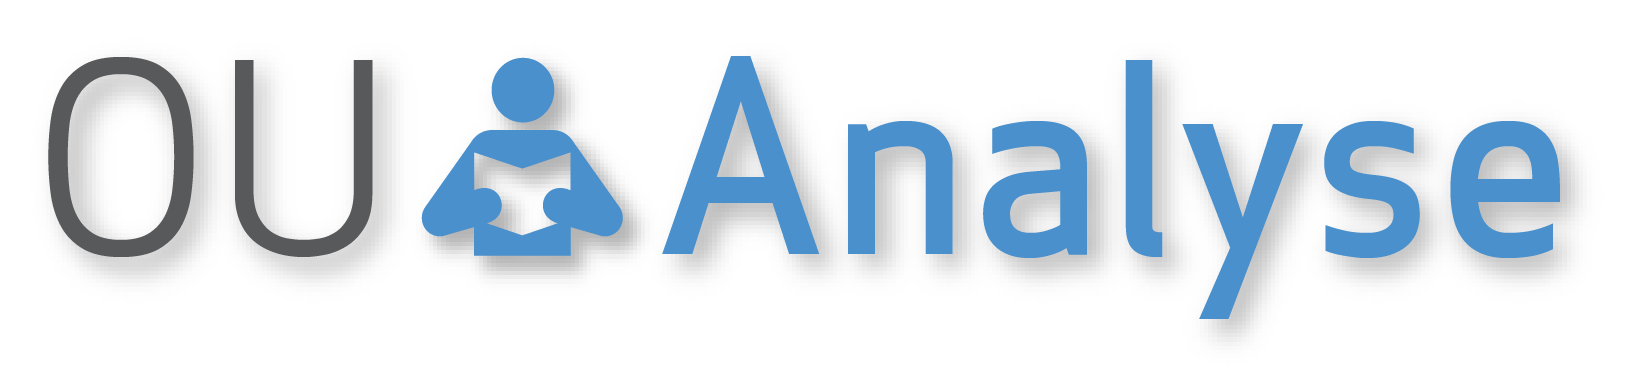

## Coded by Nathan and Mitchell.

# IMPORT STATEMENTS

In [1]:
#data manipulation imports
import pandas as pd
import numpy as np

#plotting imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#machine learning imports
from scipy import stats
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn import tree 
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier

#statistics import
import statistics
import math

#for plots to appear in the Notebook
%matplotlib inline

# SPLITTING DATASETS INTO TRAIN AND TEST
### WARNING: should only be ran for a new random partition of train and test!

In [2]:
# import csv
# import operator
# import random

# TRAIN_SET_PERCENTAGE = 0.4

# STUDENT_INFO = 'studentInfo.csv'
# TRAIN_STUDENT_INFO = 'studentInfoTrain.csv'
# TEST_STUDENT_INFO = 'studentInfoTest.csv'

# STUDENT_VLE = 'studentVle.csv'
# TRAIN_STUDENT_VLE = 'studentVleTrain.csv'
# TEST_STUDENT_VLE = 'studentVleTest.csv'

# if __name__ == '__main__':
#     # GET ALL STUDENT IDS
#     student_ids = list()

#     with open(STUDENT_INFO) as student_info:
#         student_info_reader = csv.reader(student_info, delimiter=',', quotechar='"')

#         for row in student_info_reader:
#             if student_info_reader.line_num == 1:
#                 continue

#             student_ids.append(row[2])

#     # SPLIT STUDENT IDS INTO TRAINING AND TEST
#     length = len(student_ids)
#     train_length = round(length * TRAIN_SET_PERCENTAGE)

#     train_indexes = random.sample(range(0, length - 1), train_length)
#     train_student_ids = set(operator.itemgetter(*train_indexes)(student_ids))
#     test_student_ids = set(student_ids).difference(set(train_student_ids))

#     # CREATE NEW DATASETS
#     for [TRAIN_FILE, TEST_FILE, STUDENT_FILE] in [[TRAIN_STUDENT_INFO, TEST_STUDENT_INFO, STUDENT_INFO],
#                                                   [TRAIN_STUDENT_VLE, TEST_STUDENT_VLE, STUDENT_VLE]]:
#         with open(TRAIN_FILE, 'w', newline='') as train_file, open(TEST_FILE, 'w', newline='') as test_file, open(
#                 STUDENT_FILE) as student_info:
#             student_info_reader = csv.reader(student_info, delimiter=',', quotechar='"')
#             train_file_writer = csv.writer(train_file)
#             test_file_writer = csv.writer(test_file)

#             for row in student_info_reader:
#                 if student_info_reader.line_num == 1:
#                     train_file_writer.writerow(row)
#                     test_file_writer.writerow(row)
#                     continue

#                 student_id = row[2]

#                 if student_id in train_student_ids:
#                     train_file_writer.writerow(row)
#                 else:
#                     test_file_writer.writerow(row)

# READING AND VIEWING THE VLE AND DEMOGRAPHIC SETS

In [3]:
# student VLE data
vle_train = pd.read_csv('studentVleTrain.csv')
vle_test = pd.read_csv('studentVleTest.csv')

# student demographic data
info_train = pd.read_csv('studentInfoTrain.csv')
info_test = pd.read_csv('studentInfoTest.csv')

In [4]:
vle_train.head(5)

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,31604,546672,-10,1
1,AAA,2013J,31604,547013,-10,5
2,AAA,2013J,31604,546871,-10,3
3,AAA,2013J,31604,546614,-10,11
4,AAA,2013J,31604,546660,-10,1


In [5]:
info_train.head(5)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
1,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass
2,AAA,2013J,45462,M,Scotland,HE Qualification,30-40%,0-35,0,60,N,Pass
3,AAA,2013J,52130,F,East Anglian Region,A Level or Equivalent,70-80%,0-35,0,90,N,Pass
4,AAA,2013J,53025,M,North Region,Post Graduate Qualification,NaN,55<=,0,60,N,Pass


# PREPROCESSING THE TRAIN AND TEST SET

In [6]:
#due to EWSs working optimally when fit to a specific course, we select only course AAA, but for all possible years 2013 & 2014
vle_train_a = vle_train.loc[vle_train.code_module == 'AAA']
vle_test_a = vle_test.loc[vle_test.code_module == 'AAA']

vle_train_a['uuid'] = vle_train_a['id_student'].astype(str) + '-' + vle_train_a['code_presentation']
vle_test_a['uuid'] = vle_test_a['id_student'].astype(str) + '-' + vle_test_a['code_presentation']

#reduce vle set to only include relevant columns
vle_train_a = vle_train_a[['uuid', 'date', 'sum_click']]
vle_test_a = vle_test_a[['uuid', 'date', 'sum_click']]

#group vle data on student id and date, while summing the clicks per day
vle_train_group = vle_train_a.groupby(['uuid', 'date']).agg({'sum_click':'sum'}).reset_index()
vle_test_group = vle_test_a.groupby(['uuid', 'date']).agg({'sum_click':'sum'}).reset_index()

#for the info set, we also select only course AAA and years 2013 & 2014
info_train_a = info_train.loc[info_train.code_module == 'AAA']
info_test_a = info_test.loc[info_test.code_module == 'AAA']

info_train_a['uuid'] = info_train_a['id_student'].astype(str) + '-' + info_train_a['code_presentation']
info_test_a['uuid'] = info_test_a['id_student'].astype(str) + '-' + info_test_a['code_presentation']

#reduce info set to only include relevant columns
info_train_a = info_train_a[['uuid', 'gender', 'highest_education', 'num_of_prev_attempts', 'final_result']]
info_test_a = info_test_a[['uuid', 'gender', 'highest_education', 'num_of_prev_attempts', 'final_result']]

#mutate the final_result column to become binary (pass/fail)
info_train_a.loc[info_train_a['gender'] == 'M', ['gender']] = 1 
info_train_a.loc[info_train_a['gender'] == 'F', ['gender']] = 0

info_test_a.loc[info_test_a['gender'] == 'M', ['gender']] = 1 
info_test_a.loc[info_test_a['gender'] == 'F', ['gender']] = 0

#mutate the final_result column to become binary (pass/fail)
info_train_a.loc[info_train_a['final_result'] == 'Distinction', ['final_result']] = 'Pass' 
info_train_a.loc[info_train_a['final_result'] == 'Withdrawn', ['final_result']] = 'Fail'

info_test_a.loc[info_test_a['final_result'] == 'Distinction', ['final_result']] = 'Pass' 
info_test_a.loc[info_test_a['final_result'] == 'Withdrawn', ['final_result']] = 'Fail'

#change num_of_prev_attempts to boolean, need to only run this once
info_train_a.loc[info_train_a['num_of_prev_attempts'] > 0, ['num_of_prev_attempts']] = 1      
info_train_a.loc[info_train_a['num_of_prev_attempts'] == 0, ['num_of_prev_attempts']] = 0

#rename column to 'continued'
info_train_a = info_train_a.rename(columns={"num_of_prev_attempts": "continued"})
                    
#do the same for the demographic test set
info_test_a.loc[info_test_a['num_of_prev_attempts'] > 0, ['num_of_prev_attempts']] = 1      
info_test_a.loc[info_test_a['num_of_prev_attempts'] == 0, ['num_of_prev_attempts']] = 0

info_test_a = info_test_a.rename(columns={"num_of_prev_attempts": "continued"})

#list and number of unique students in course AAA (*train)
unique_train = np.sort(vle_train_a['uuid'].unique())
print('Number of unique students in TRAIN: %s' % (vle_train_a['uuid'].nunique()))

#list and number of unique students in course AAA (*test)
unique_test = np.sort(vle_test_a['uuid'].unique())
print('Number of unique students in TEST: %s' % (vle_test_a['uuid'].nunique()))

print('Minimum date in TRAIN: %s' % (vle_train_group['date'].min()))
print('Minimum date in TEST: %s' % (vle_test_group['date'].min()))
print('Maximum date in TRAIN: %s' % (vle_train_group['date'].max()))
print('Maximum date in TEST: %s' % (vle_test_group['date'].max()))

min_date = vle_train_group['date'].min()
max_date = vle_train_group['date'].max()

#creating dataframe for all combinations of students and dates to merge with the full train set 
student_train = pd.DataFrame(data=unique_train, columns=['uuid'])
date_train = pd.DataFrame(pd.Series(range(min_date, max_date + 1)), columns=['date'])

student_train['one'] = 1
date_train['one'] = 1
all_dates_train = pd.merge(student_train, date_train, on='one').drop('one', axis=1)

#merging with the full train set and adding value of 0 to sum_click on inactive days
all_train = pd.merge(all_dates_train, vle_train_group, how = 'outer', on = ['uuid', 'date'])
all_train['sum_click'] = all_train['sum_click'].fillna(0).astype(int)

#group by student id for cumulative clicks per day
all_train['cum_sum'] = all_train.groupby('uuid')['sum_click'].transform(pd.Series.cumsum)

#merge (left join) vle and demo dataframes on student id
all_train = pd.merge(all_train, info_train_a, on = 'uuid')

#creating dataframe for all combinations of students and dates to merge with the full test set 
student_test = pd.DataFrame(data=unique_test, columns=['uuid'])
date_test = pd.DataFrame(pd.Series(range(min_date, max_date + 1)), columns=['date'])

student_test['one'] = 1
date_test['one'] = 1
all_dates_test = pd.merge(student_test, date_test, on='one').drop('one', axis=1)

#merging with all_test and adding value of 0 to sum_click on inactive days
all_test = pd.merge(all_dates_test, vle_test_group, how = 'outer', on = ['uuid', 'date'])
all_test['sum_click'] = all_test['sum_click'].fillna(0).astype(int)

#group by student id for cumulative clicks per day
all_test['cum_sum'] = all_test.groupby('uuid')['sum_click'].transform(pd.Series.cumsum)

#merge (left join) vle and demo dataframes on student id
all_test = pd.merge(all_test, info_test_a, on = 'uuid')

<ipython-input-6-7f50b5a25680>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vle_train_a['uuid'] = vle_train_a['id_student'].astype(str) + '-' + vle_train_a['code_presentation']
<ipython-input-6-7f50b5a25680>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vle_test_a['uuid'] = vle_test_a['id_student'].astype(str) + '-' + vle_test_a['code_presentation']
<ipython-input-6-7f50b5a25680>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Number of unique students in TRAIN: 330
Number of unique students in TEST: 405
Minimum date in TRAIN: -24
Minimum date in TEST: -24
Maximum date in TRAIN: 269
Maximum date in TEST: 269


# INSPECTING OUR TRAIN AND TEST SET

In [7]:
all_train.head(10)

,uuid,date,sum_click,cum_sum,gender,highest_education,continued,final_result
0,101116-2014J,-24,63,63,0,Lower Than A Level,0,Pass
1,101116-2014J,-23,8,71,0,Lower Than A Level,0,Pass
2,101116-2014J,-22,0,71,0,Lower Than A Level,0,Pass
3,101116-2014J,-21,0,71,0,Lower Than A Level,0,Pass
4,101116-2014J,-20,10,81,0,Lower Than A Level,0,Pass
5,101116-2014J,-19,0,81,0,Lower Than A Level,0,Pass
6,101116-2014J,-18,0,81,0,Lower Than A Level,0,Pass
7,101116-2014J,-17,0,81,0,Lower Than A Level,0,Pass
8,101116-2014J,-16,0,81,0,Lower Than A Level,0,Pass
9,101116-2014J,-15,7,88,0,Lower Than A Level,0,Pass


In [8]:
all_test.head(10)

,uuid,date,sum_click,cum_sum,gender,highest_education,continued,final_result
0,100893-2013J,-24,0,0,1,A Level or Equivalent,0,Pass
1,100893-2013J,-23,0,0,1,A Level or Equivalent,0,Pass
2,100893-2013J,-22,0,0,1,A Level or Equivalent,0,Pass
3,100893-2013J,-21,0,0,1,A Level or Equivalent,0,Pass
4,100893-2013J,-20,0,0,1,A Level or Equivalent,0,Pass
5,100893-2013J,-19,0,0,1,A Level or Equivalent,0,Pass
6,100893-2013J,-18,0,0,1,A Level or Equivalent,0,Pass
7,100893-2013J,-17,0,0,1,A Level or Equivalent,0,Pass
8,100893-2013J,-16,0,0,1,A Level or Equivalent,0,Pass
9,100893-2013J,-15,0,0,1,A Level or Equivalent,0,Pass


# (SANITY) CHECKS

In [9]:
print('Minimum date in TRAIN: %s' % (all_train['date'].min()))
print('Minimum date in TEST: %s' % (all_test['date'].min()))
print('Maximum date in TRAIN: %s' % (all_train['date'].max()))
print('Maximum date in TEST: %s' % (all_test['date'].max()))

Minimum date in TRAIN: -24
Minimum date in TEST: -24
Maximum date in TRAIN: 269
Maximum date in TEST: 269


In [10]:
train_pass = len(all_train.loc[all_test['final_result'] == 'Pass'])
train_fail = len(all_train.loc[all_test['final_result'] == 'Fail'])

train = len(all_train['uuid'].unique())

print('Number of total pass + fail divided by total days in TRAIN: %s' % ((train_pass + train_fail) / ((max_date + 1) + (min_date * -1))))

print('Number of unique students in TRAIN: %s' % (train))

test_pass = len(all_test.loc[all_test['final_result'] == 'Pass'])
test_fail = len(all_test.loc[all_test['final_result'] == 'Fail'])

test = len(all_test['uuid'].unique())

print('Number of total pass + fail divided by total days in TEST: %s' % ((test_pass + test_fail) / ((max_date + 1) + (min_date * -1))))

print('Number of unique students in TEST: %s' % (test))

Number of total pass + fail divided by total days in TRAIN: 330.0
Number of unique students in TRAIN: 330
Number of total pass + fail divided by total days in TEST: 405.0
Number of unique students in TEST: 405


# TRAINING AND TESTING ON OUR DATASET

In [11]:
#make empty lists to score the metric results
dt_accuracy_scores = []
dt_precision_pass_l = []
dt_recall_pass_l = []
dt_fscore_pass_l = []

dt_precision_fail_l = []
dt_recall_fail_l = []
dt_fscore_fail_l = []

svc_accuracy_scores = []
svc_precision_pass_l = []
svc_recall_pass_l = []
svc_fscore_pass_l = []

svc_precision_fail_l = []
svc_recall_fail_l = []
svc_fscore_fail_l = []

rf_accuracy_scores = []
rf_precision_pass_l = []
rf_recall_pass_l = []
rf_fscore_pass_l = []

rf_precision_fail_l = []
rf_recall_fail_l = []
rf_fscore_fail_l = []

nb_accuracy_scores = []
nb_precision_pass_l = []
nb_recall_pass_l = []
nb_fscore_pass_l = []

nb_precision_fail_l = []
nb_recall_fail_l = []
nb_fscore_fail_l = []

#as shown earlier, the minimal date is -24 and the maximum date is 269, so a range from -24 to 270
for i in range(min_date, max_date + 1):  
    #as we have already calulated the cumulative sum of clicks per day, we do not need to train on the all_train['date'] <= i,
    #as this would be redudant
    train = all_train.loc[all_train['date'] == i]
    
    train_feature = train[['cum_sum', 'gender', 'continued']]
    train_result = train['final_result']
    
    #as sklearn classifiers do not support categorical variables (which is desperately needed), we one-hot-encode   
    #the highest_education feature, where the first column is A Level or Equivalent, the second is HE Qualification
    #the third is Lower than A Level and the fourth is Post Graduate Qualification
    enc = OneHotEncoder(sparse = False)  
    transformed = enc.fit_transform(train[['highest_education']].to_numpy())
    a_level = transformed[:,0]
    he_qual = transformed[:,1]
    below_a = transformed[:,2]
    post_grad = transformed[:,3]

    train_a_level = pd.DataFrame(a_level, columns= ['a_level'])
    train_he_qual = pd.DataFrame(he_qual, columns= ['he_qual'])
    train_below_a = pd.DataFrame(below_a, columns= ['below_a'])
    train_post_grad = pd.DataFrame(post_grad, columns= ['post_grad'])
    train_feature = pd.concat([train_feature.reset_index(drop=True), train_a_level.reset_index(drop=True)], axis=1)
    train_feature = pd.concat([train_feature.reset_index(drop=True), train_he_qual.reset_index(drop=True)], axis=1)
    train_feature = pd.concat([train_feature.reset_index(drop=True), train_below_a.reset_index(drop=True)], axis=1)
    train_feature = pd.concat([train_feature.reset_index(drop=True), train_post_grad.reset_index(drop=True)], axis=1)
    
    #we perform precisely the same steps for the test set
    test = all_test.loc[all_test['date'] == i]
    
    test_feature = test[['cum_sum', 'gender', 'continued']]
    test_result = test['final_result']
    
    enc = OneHotEncoder(sparse = False)  
    transformed = enc.fit_transform(test[['highest_education']].to_numpy())
    a_level = transformed[:,0]
    he_qual = transformed[:,1]
    below_a = transformed[:,2]
    post_grad = transformed[:,3]

    test_a_level = pd.DataFrame(a_level, columns= ['a_level'])
    test_he_qual = pd.DataFrame(he_qual, columns= ['he_qual'])
    test_below_a = pd.DataFrame(below_a, columns= ['below_a'])
    test_post_grad = pd.DataFrame(post_grad, columns= ['post_grad'])
    test_feature = pd.concat([test_feature.reset_index(drop=True), test_a_level.reset_index(drop=True)], axis=1)
    test_feature = pd.concat([test_feature.reset_index(drop=True), test_he_qual.reset_index(drop=True)], axis=1)
    test_feature = pd.concat([test_feature.reset_index(drop=True), test_below_a.reset_index(drop=True)], axis=1)
    test_feature = pd.concat([test_feature.reset_index(drop=True), test_post_grad.reset_index(drop=True)], axis=1)
    
    #UNCOMMENT THE CLASSIFIER THAT YOU WOULD TO USE BELOW!
    
    #Balanced Decision tree 
    #strangely, balancing has little influence on the results, but nevertheless should be performed on imbalanced data
    clf1 = tree.DecisionTreeClassifier(class_weight='balanced')
    clf1.fit(train_feature.to_numpy(), train_result.to_numpy())
    output1 = clf1.predict(test_feature.to_numpy())
    
    #Balanced RBF kernel Support Vector Classification (SVC) 
    #rbf outperforms other kernels on standard settings
    clf2 = svm.SVC(kernel='rbf', class_weight= 'balanced')
    clf2.fit(train_feature.to_numpy(), train_result.to_numpy())
    output2 = clf2.predict(test_feature.to_numpy())

    #Balanced Random Forest
    clf3 = RandomForestClassifier(class_weight='balanced')
    clf3.fit(train_feature.to_numpy(), train_result.to_numpy())
    output3 = clf3.predict(test_feature.to_numpy())
    
    #Unbalanced Gaussian Naive Bayes
    #this classifier has no built in class weighing
    clf4 = GaussianNB()
    clf4.fit(train_feature.to_numpy(), train_result.to_numpy())
    output4 = clf4.predict(test_feature.to_numpy())
    
    #extract precision, recall, and fscore from the results for each label
    precision_pass, recall_pass, fscore_pass, support = score(test_result, output1, labels = ['Pass'])
    precision_fail, recall_fail, fscore_fail, support = score(test_result, output1, labels = ['Fail'])
    
    #append accuracy scores to the list
    dt_accuracy_scores.append(metrics.accuracy_score(test_result, output1))
    
    #metrics for 'Pass' label
    dt_precision_pass_l = np.append(dt_precision_pass_l, precision_pass)
    dt_recall_pass_l = np.append(dt_recall_pass_l, recall_pass)
    dt_fscore_pass_l = np.append(dt_fscore_pass_l, fscore_pass)
    
    #metrics for 'Fail' label
    dt_precision_fail_l = np.append(dt_precision_fail_l, precision_fail)    
    dt_recall_fail_l = np.append(dt_recall_fail_l, recall_fail)    
    dt_fscore_fail_l = np.append(dt_fscore_fail_l, fscore_fail)
    
    precision_pass, recall_pass, fscore_pass, support = score(test_result, output2, labels = ['Pass'])
    precision_fail, recall_fail, fscore_fail, support = score(test_result, output2, labels = ['Fail'])
    
    #append accuracy scores to the list
    svc_accuracy_scores.append(metrics.accuracy_score(test_result, output2))
    
    #metrics for 'Pass' label
    svc_precision_pass_l = np.append(svc_precision_pass_l, precision_pass)
    svc_recall_pass_l = np.append(svc_recall_pass_l, recall_pass)
    svc_fscore_pass_l = np.append(svc_fscore_pass_l, fscore_pass)
    
    #metrics for 'Fail' label
    svc_precision_fail_l = np.append(svc_precision_fail_l, precision_fail)    
    svc_recall_fail_l = np.append(svc_recall_fail_l, recall_fail)    
    svc_fscore_fail_l = np.append(svc_fscore_fail_l, fscore_fail)
    
    precision_pass, recall_pass, fscore_pass, support = score(test_result, output3, labels = ['Pass'])
    precision_fail, recall_fail, fscore_fail, support = score(test_result, output3, labels = ['Fail'])
    
    #append accuracy scores to the list
    rf_accuracy_scores.append(metrics.accuracy_score(test_result, output3))
    
    #metrics for 'Pass' label
    rf_precision_pass_l = np.append(rf_precision_pass_l, precision_pass)
    rf_recall_pass_l = np.append(rf_recall_pass_l, recall_pass)
    rf_fscore_pass_l = np.append(rf_fscore_pass_l, fscore_pass)
    
    #metrics for 'Fail' label
    rf_precision_fail_l = np.append(rf_precision_fail_l, precision_fail)    
    rf_recall_fail_l = np.append(rf_recall_fail_l, recall_fail)    
    rf_fscore_fail_l = np.append(rf_fscore_fail_l, fscore_fail)
    
    precision_pass, recall_pass, fscore_pass, support = score(test_result, output4, labels = ['Pass'])
    precision_fail, recall_fail, fscore_fail, support = score(test_result, output4, labels = ['Fail'])
    
    #append accuracy scores to the list
    nb_accuracy_scores.append(metrics.accuracy_score(test_result, output4))
    
    #metrics for 'Pass' label
    nb_precision_pass_l = np.append(nb_precision_pass_l, precision_pass)
    nb_recall_pass_l = np.append(nb_recall_pass_l, recall_pass)
    nb_fscore_pass_l = np.append(nb_fscore_pass_l, fscore_pass)
    
    #metrics for 'Fail' label
    nb_precision_fail_l = np.append(nb_precision_fail_l, precision_fail)    
    nb_recall_fail_l = np.append(nb_recall_fail_l, recall_fail)    
    nb_fscore_fail_l = np.append(nb_fscore_fail_l, fscore_fail)

In [12]:
date = range(min_date, max_date + 1)

#calculate the median of the date range and round it up to the nearest integer
median_date_ind = math.ceil(statistics.median(range(0, max_date + 1)))

In [14]:
#the initial metrics of the classifier in question (day 0, start of course)
print('DECISION TREE METRICS')
print('DAY %i' % (min_date + min_date * -1))
print('Accuracy: %.3f \n' % (dt_accuracy_scores[min_date * -1]))

print('Precision (Pass): %.3f' % (dt_precision_pass_l[min_date * -1]))
print('Recall (Pass): %.3f' % (dt_recall_pass_l[min_date * -1]))
print('F-score (Pass): %.3f \n' % (dt_fscore_pass_l[min_date * -1]))

print('Precision (Fail): %.3f' % (dt_precision_fail_l[min_date * -1]))
print('Recall (Fail): %.3f' % (dt_recall_fail_l[min_date * -1]))
print('F-score (Fail): %.3f \n\n' % (dt_fscore_fail_l[min_date * -1]))

#the median metrics of the classifier in question (day 269)
print('DAY %i' % (median_date_ind))
print('Accuracy: %.3f \n' % (dt_accuracy_scores[median_date_ind]))

print('Precision (Pass): %.3f' % (dt_precision_pass_l[median_date_ind]))
print('Recall (Pass): %.3f' % (dt_recall_pass_l[median_date_ind]))
print('F-score (Pass): %.3f \n' % (dt_fscore_pass_l[median_date_ind]))

print('Precision (Fail): %.3f' % (dt_precision_fail_l[median_date_ind]))
print('Recall (Fail): %.3f' % (dt_recall_fail_l[median_date_ind]))
print('F-score (Fail): %.3f \n\n' % (dt_fscore_fail_l[median_date_ind]))

#the best metrics of the classifier in question (day ?)
print('BEST DAY')
print('Day %i: Accuracy: %.3f \n' % (dt_accuracy_scores.index(max(dt_accuracy_scores)), max(dt_accuracy_scores)))

print('Day %i: Precision (Pass): %.3f' % (dt_precision_pass_l.argmax() - (min_date * -1), max(dt_precision_pass_l)))
print('Day %i: Recall (Pass): %.3f' % (dt_recall_pass_l.argmax() - (min_date * -1), max(dt_recall_pass_l)))
print('Day %i: F-score (Pass): %.3f \n' % (dt_fscore_pass_l.argmax() - (min_date * -1), max(dt_fscore_pass_l)))

print('Day %i: Precision (Fail): %.3f' % (dt_precision_fail_l.argmax() - (min_date * -1), max(dt_precision_fail_l)))
print('Day %i: Recall (Fail): %.3f' % (dt_recall_fail_l.argmax() - (min_date * -1), max(dt_recall_fail_l)))
print('Day %i: F-score (Fail): %.3f \n\n\n' % (dt_fscore_fail_l.argmax() - (min_date * -1), max(dt_fscore_fail_l)))



#the initial metrics of the classifier in question (day 0, start of course)
print('SVC METRICS')
print('DAY %i' % (min_date + min_date * -1))
print('Accuracy: %.3f \n' % (svc_accuracy_scores[min_date * -1]))

print('Precision (Pass): %.3f' % (svc_precision_pass_l[min_date * -1]))
print('Recall (Pass): %.3f' % (svc_recall_pass_l[min_date * -1]))
print('F-score (Pass): %.3f \n' % (svc_fscore_pass_l[min_date * -1]))

print('Precision (Fail): %.3f' % (svc_precision_fail_l[min_date * -1]))
print('Recall (Fail): %.3f' % (svc_recall_fail_l[min_date * -1]))
print('F-score (Fail): %.3f \n\n' % (svc_fscore_fail_l[min_date * -1]))

#the median metrics of the classifier in question (day 269)
print('DAY %i' % (median_date_ind))
print('Accuracy: %.3f \n' % (svc_accuracy_scores[median_date_ind]))

print('Precision (Pass): %.3f' % (svc_precision_pass_l[median_date_ind]))
print('Recall (Pass): %.3f' % (svc_recall_pass_l[median_date_ind]))
print('F-score (Pass): %.3f \n' % (svc_fscore_pass_l[median_date_ind]))

print('Precision (Fail): %.3f' % (svc_precision_fail_l[median_date_ind]))
print('Recall (Fail): %.3f' % (svc_recall_fail_l[median_date_ind]))
print('F-score (Fail): %.3f \n\n' % (svc_fscore_fail_l[median_date_ind]))

#the best metrics of the classifier in question (day ?)
print('BEST DAY')
print('Day %i: Accuracy: %.3f \n' % (svc_accuracy_scores.index(max(svc_accuracy_scores)), max(svc_accuracy_scores)))

print('Day %i: Precision (Pass): %.3f' % (svc_precision_pass_l.argmax() - (min_date * -1), max(svc_precision_pass_l)))
print('Day %i: Recall (Pass): %.3f' % (svc_recall_pass_l.argmax() - (min_date * -1), max(svc_recall_pass_l)))
print('Day %i: F-score (Pass): %.3f \n' % (svc_fscore_pass_l.argmax() - (min_date * -1), max(svc_fscore_pass_l)))

print('Day %i: Precision (Fail): %.3f' % (svc_precision_fail_l.argmax() - (min_date * -1), max(svc_precision_fail_l)))
print('Day %i: Recall (Fail): %.3f' % (svc_recall_fail_l.argmax() - (min_date * -1), max(svc_recall_fail_l)))
print('Day %i: F-score (Fail): %.3f \n\n\n' % (svc_fscore_fail_l.argmax() - (min_date * -1), max(svc_fscore_fail_l)))



#the initial metrics of the classifier in question (day 0, start of course)
print('RF METRICS')
print('DAY %i' % (min_date + min_date * -1))
print('Accuracy: %.3f \n' % (rf_accuracy_scores[min_date * -1]))

print('Precision (Pass): %.3f' % (rf_precision_pass_l[min_date * -1]))
print('Recall (Pass): %.3f' % (rf_recall_pass_l[min_date * -1]))
print('F-score (Pass): %.3f \n' % (rf_fscore_pass_l[min_date * -1]))

print('Precision (Fail): %.3f' % (rf_precision_fail_l[min_date * -1]))
print('Recall (Fail): %.3f' % (rf_recall_fail_l[min_date * -1]))
print('F-score (Fail): %.3f \n\n' % (rf_fscore_fail_l[min_date * -1]))

#the median metrics of the classifier in question (day 269)
print('DAY %i' % (median_date_ind))
print('Accuracy: %.3f \n' % (rf_accuracy_scores[median_date_ind]))

print('Precision (Pass): %.3f' % (rf_precision_pass_l[median_date_ind]))
print('Recall (Pass): %.3f' % (rf_recall_pass_l[median_date_ind]))
print('F-score (Pass): %.3f \n' % (rf_fscore_pass_l[median_date_ind]))

print('Precision (Fail): %.3f' % (rf_precision_fail_l[median_date_ind]))
print('Recall (Fail): %.3f' % (rf_recall_fail_l[median_date_ind]))
print('F-score (Fail): %.3f \n\n' % (rf_fscore_fail_l[median_date_ind]))

#the best metrics of the classifier in question (day ?)
print('BEST DAY')
print('Day %i: Accuracy: %.3f \n' % (rf_accuracy_scores.index(max(rf_accuracy_scores)), max(rf_accuracy_scores)))

print('Day %i: Precision (Pass): %.3f' % (rf_precision_pass_l.argmax() - (min_date * -1), max(rf_precision_pass_l)))
print('Day %i: Recall (Pass): %.3f' % (rf_recall_pass_l.argmax() - (min_date * -1), max(rf_recall_pass_l)))
print('Day %i: F-score (Pass): %.3f \n' % (rf_fscore_pass_l.argmax() - (min_date * -1), max(rf_fscore_pass_l)))

print('Day %i: Precision (Fail): %.3f' % (rf_precision_fail_l.argmax() - (min_date * -1), max(rf_precision_fail_l)))
print('Day %i: Recall (Fail): %.3f' % (rf_recall_fail_l.argmax() - (min_date * -1), max(rf_recall_fail_l)))
print('Day %i: F-score (Fail): %.3f \n\n\n' % (rf_fscore_fail_l.argmax() - (min_date * -1), max(rf_fscore_fail_l)))



#the initial metrics of the classifier in question (day 0, start of course)
print('NB METRICS')
print('DAY %i' % (min_date + min_date * -1))
print('Accuracy: %.3f \n' % (nb_accuracy_scores[min_date * -1]))

print('Precision (Pass): %.3f' % (nb_precision_pass_l[min_date * -1]))
print('Recall (Pass): %.3f' % (nb_recall_pass_l[min_date * -1]))
print('F-score (Pass): %.3f \n' % (nb_fscore_pass_l[min_date * -1]))

print('Precision (Fail): %.3f' % (nb_precision_fail_l[min_date * -1]))
print('Recall (Fail): %.3f' % (nb_recall_fail_l[min_date * -1]))
print('F-score (Fail): %.3f \n\n' % (nb_fscore_fail_l[min_date * -1]))

#the median metrics of the classifier in question (day 269)
print('DAY %i' % (median_date_ind))
print('Accuracy: %.3f \n' % (nb_accuracy_scores[median_date_ind]))

print('Precision (Pass): %.3f' % (nb_precision_pass_l[median_date_ind]))
print('Recall (Pass): %.3f' % (nb_recall_pass_l[median_date_ind]))
print('F-score (Pass): %.3f \n' % (nb_fscore_pass_l[median_date_ind]))

print('Precision (Fail): %.3f' % (nb_precision_fail_l[median_date_ind]))
print('Recall (Fail): %.3f' % (nb_recall_fail_l[median_date_ind]))
print('F-score (Fail): %.3f \n\n' % (nb_fscore_fail_l[median_date_ind]))

#the best metrics of the classifier in question (day ?)
print('BEST DAY')
print('Day %i: Accuracy: %.3f \n' % (nb_accuracy_scores.index(max(nb_accuracy_scores)), max(nb_accuracy_scores)))

print('Day %i: Precision (Pass): %.3f' % (nb_precision_pass_l.argmax() - (min_date * -1), max(nb_precision_pass_l)))
print('Day %i: Recall (Pass): %.3f' % (nb_recall_pass_l.argmax() - (min_date * -1), max(nb_recall_pass_l)))
print('Day %i: F-score (Pass): %.3f \n' % (nb_fscore_pass_l.argmax() - (min_date * -1), max(nb_fscore_pass_l)))

print('Day %i: Precision (Fail): %.3f' % (nb_precision_fail_l.argmax() - (min_date * -1), max(nb_precision_fail_l)))
print('Day %i: Recall (Fail): %.3f' % (nb_recall_fail_l.argmax() - (min_date * -1), max(nb_recall_fail_l)))
print('Day %i: F-score (Fail): %.3f' % (nb_fscore_fail_l.argmax() - (min_date * -1), max(nb_fscore_fail_l)))

DECISION TREE METRICS
DAY 0
Accuracy: 0.600 

Precision (Pass): 0.765
Recall (Pass): 0.674
F-score (Pass): 0.717 

Precision (Fail): 0.277
Recall (Fail): 0.376
F-score (Fail): 0.319 


DAY 135
Accuracy: 0.635 

Precision (Pass): 0.789
Recall (Pass): 0.701
F-score (Pass): 0.742 

Precision (Fail): 0.326
Recall (Fail): 0.436
F-score (Fail): 0.373 


BEST DAY
Day 228: Accuracy: 0.714 

Day 204: Precision (Pass): 0.831
Day 233: Recall (Pass): 0.819
Day 236: F-score (Pass): 0.807 

Day 204: Precision (Fail): 0.438
Day -18: Recall (Fail): 0.604
Day 204: F-score (Fail): 0.477 



SVC METRICS
DAY 0
Accuracy: 0.622 

Precision (Pass): 0.839
Recall (Pass): 0.615
F-score (Pass): 0.710 

Precision (Fail): 0.357
Recall (Fail): 0.644
F-score (Fail): 0.459 


DAY 135
Accuracy: 0.662 

Precision (Pass): 0.871
Recall (Pass): 0.645
F-score (Pass): 0.741 

Precision (Fail): 0.400
Recall (Fail): 0.713
F-score (Fail): 0.512 


BEST DAY
Day 86: Accuracy: 0.679 

Day 266: Precision (Pass): 0.908
Day 22: Reca

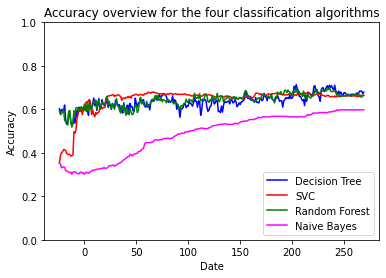

In [15]:
#plotting the accuracy
plt.plot(date, dt_accuracy_scores, "-", color = 'blue', label = 'Decision Tree')
plt.plot(date, svc_accuracy_scores, "-", color = 'red', label = 'SVC')
plt.plot(date, rf_accuracy_scores, "-", color = 'green', label = 'Random Forest')
plt.plot(date, nb_accuracy_scores, "-", color = 'magenta', label = 'Naive Bayes')
plt.legend(loc = 'lower right')

plt.title('Accuracy overview for the four classification algorithms')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.savefig('Accuracy overview for the four classification algorithms.png', dpi=300)

plt.show()

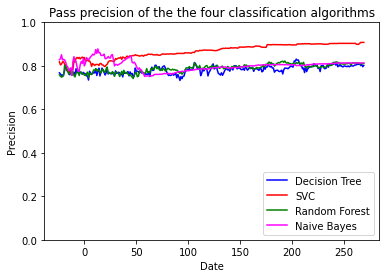

In [16]:
#plotting the precision
#how many of the total predicted positives/negatives are true?

plt.plot(date, dt_precision_pass_l, "-", color = 'blue', label = 'Decision Tree')
plt.plot(date, svc_precision_pass_l, "-", color = 'red', label = 'SVC')
plt.plot(date, rf_precision_pass_l, "-", color = 'green', label = 'Random Forest')
plt.plot(date, nb_precision_pass_l, "-", color = 'magenta', label = 'Naive Bayes')
plt.legend(loc = 'lower right')

plt.title('Pass precision of the the four classification algorithms')
plt.xlabel('Date')
plt.ylabel('Precision')
plt.ylim(0, 1)

plt.savefig('Pass precision of the the four classification algorithms.png', dpi=300)

plt.show()

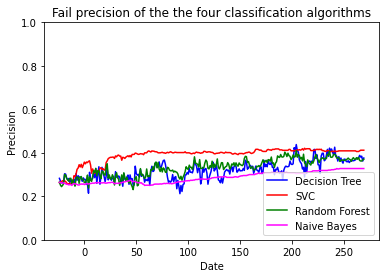

In [17]:
#plotting the precision
#how many of the total predicted positives/negatives are true?

plt.plot(date, dt_precision_fail_l, "-", color = 'blue', label = 'Decision Tree')
plt.plot(date, svc_precision_fail_l, "-", color = 'red', label = 'SVC')
plt.plot(date, rf_precision_fail_l, "-", color = 'green',label = 'Random Forest')
plt.plot(date, nb_precision_fail_l, "-", color = 'magenta',label = 'Naive Bayes')
plt.legend(loc = 'lower right')

plt.title('Fail precision of the the four classification algorithms')
plt.xlabel('Date')
plt.ylabel('Precision')
plt.ylim(0, 1)

plt.savefig('Fail precision of the the four classification algorithms.png', dpi=300)

plt.show()

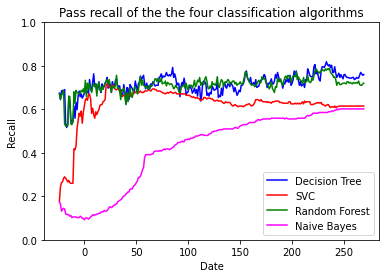

In [18]:
#plotting the recall
#how many of the total actual positives/negatives are classified correctly?

plt.plot(date, dt_recall_pass_l, "-", color = 'blue', label = 'Decision Tree')
plt.plot(date, svc_recall_pass_l, "-", color = 'red', label = 'SVC')
plt.plot(date, rf_recall_pass_l, "-", color = 'green',label = 'Random Forest')
plt.plot(date, nb_recall_pass_l, "-", color = 'magenta',label = 'Naive Bayes')
plt.legend(loc = 'lower right')

plt.title('Pass recall of the the four classification algorithms')
plt.xlabel('Date')
plt.ylabel('Recall')
plt.ylim(0, 1)

plt.savefig('Pass recall of the the four classification algorithms.png', dpi=300)

plt.show()

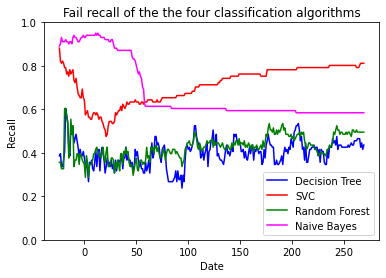

In [19]:
#plotting the recall
#how many of the total actual positives/negatives are classified correctly?

plt.plot(date, dt_recall_fail_l, "-", color = 'blue', label = 'Decision Tree')
plt.plot(date, svc_recall_fail_l, "-", color = 'red', label = 'SVC')
plt.plot(date, rf_recall_fail_l, "-", color = 'green',label = 'Random Forest')
plt.plot(date, nb_recall_fail_l, "-", color = 'magenta',label = 'Naive Bayes')
plt.legend(loc = 'lower right')

plt.title('Fail recall of the the four classification algorithms')
plt.xlabel('Date')
plt.ylabel('Recall')
plt.ylim(0, 1)

plt.savefig('Fail recall of the the four classification algorithms.png', dpi=300)

plt.show()

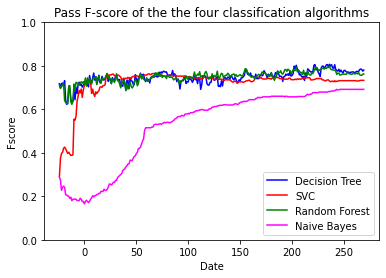

In [20]:
#plotting the f-score
#harmonic mean of the precision and recall

plt.plot(date, dt_fscore_pass_l, "-", color = 'blue', label = 'Decision Tree')
plt.plot(date, svc_fscore_pass_l, "-", color = 'red', label = 'SVC')
plt.plot(date, rf_fscore_pass_l, "-", color = 'green',label = 'Random Forest')
plt.plot(date, nb_fscore_pass_l, "-", color = 'magenta',label = 'Naive Bayes')
plt.legend(loc = 'lower right')

plt.title('Pass F-score of the the four classification algorithms')
plt.xlabel('Date')
plt.ylabel('Fscore')
plt.ylim(0, 1)

plt.savefig('Pass F-score of the the four classification algorithms.png', dpi = 300)

plt.show()

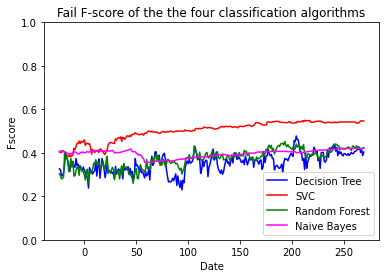

In [21]:
#plotting the f-score
#harmonic mean of the precision and recall

plt.plot(date, dt_fscore_fail_l, "-", color = 'blue', label = 'Decision Tree')
plt.plot(date, svc_fscore_fail_l, "-", color = 'red', label = 'SVC')
plt.plot(date, rf_fscore_fail_l, "-", color = 'green',label = 'Random Forest')
plt.plot(date, nb_fscore_fail_l, "-", color = 'magenta',label = 'Naive Bayes')
plt.legend(loc = 'lower right')

plt.title('Fail F-score of the the four classification algorithms')
plt.xlabel('Date')
plt.ylabel('Fscore')
plt.ylim(0, 1)

plt.savefig('Fail F-score of the the four classification algorithms.png', dpi = 300)

plt.show()

## PLOT TREE ON DAY 269

In [ ]:
#only works if you have used the Decision Tree, plots the Decision Tree
plt.figure(dpi = 300)
tree.plot_tree(clf1, filled = True)
plt.savefig('tree.pdf', bbox_inches= 'tight')
plt.show()